In [1]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

## Do Deeper Networks Solve the Problem?

If $\frac{|\lambda_{2}|}{|\lambda_{1}|}$ is large, then $A^{k}x$ requires $k>>0$ to converge, and $d_{Katz}$ likewise approaches $d_{eig}$ at slower rate. As such, we posit that deeper GCNs are required to learn the structure of low-density, high eigenvalue-ratio networks. 

### Model and Dataset Code

In [2]:
num_graphs = 3000
d = []
for _ in range(num_graphs):
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d,position=0):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    v = 1/(1.01*torch.norm(torch.eig(adj.to_dense())[0],dim=1).max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T) - torch.eye(adj.size(0)),dim=1)
    G.y = y
    d[idx] = G
    
train,test = d[:2000],d[2000::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

TypeError: 'position' is an invalid keyword argument for enumerate()

In [4]:
def batched_MAP(X,edge_index,edge_weights):
    X = X/torch.norm(X,dim=1)[:,None]
    cosine = 1 - torch.sum(X[edge_index[0]] * X[edge_index[1]],dim=1)
    return 1/edge_weights.sum() * (edge_weights * cosine).sum()

In [6]:
graph_results = []
model_mad = []

for k in [1,2,4,8,16,32,64]:
    graph = GraphConv(1,32,1,k).cuda()
    
    graph_results.append(train_loop(graph,train_loader,test_loader,50,lr=1e-1))
    torch.cuda.empty_cache()

    MAD = torch.zeros(k+1)
    for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        row,col = data.edge_index[0].cuda(),data.edge_index[1].cuda()
        batch = data.batch.cuda()

        graph.eval()
        X = graph.start(X)
        MAD[0] += batched_MAP(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()

        for jdx,m in enumerate(graph.intermediate):
            X = X + m[0](X) + torch_scatter.scatter_sum(m[1](X)[col], row.cuda(),dim=0)
            X = torch.nn.LeakyReLU()(graph.bn[jdx](X))
            MAD[jdx+1] += batched_MAP(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()

        
    model_mad.append(MAD/(idx+1))

139361: 100%|██████████| 50/50 [11:47<00:00, 14.16s/it]


### Results

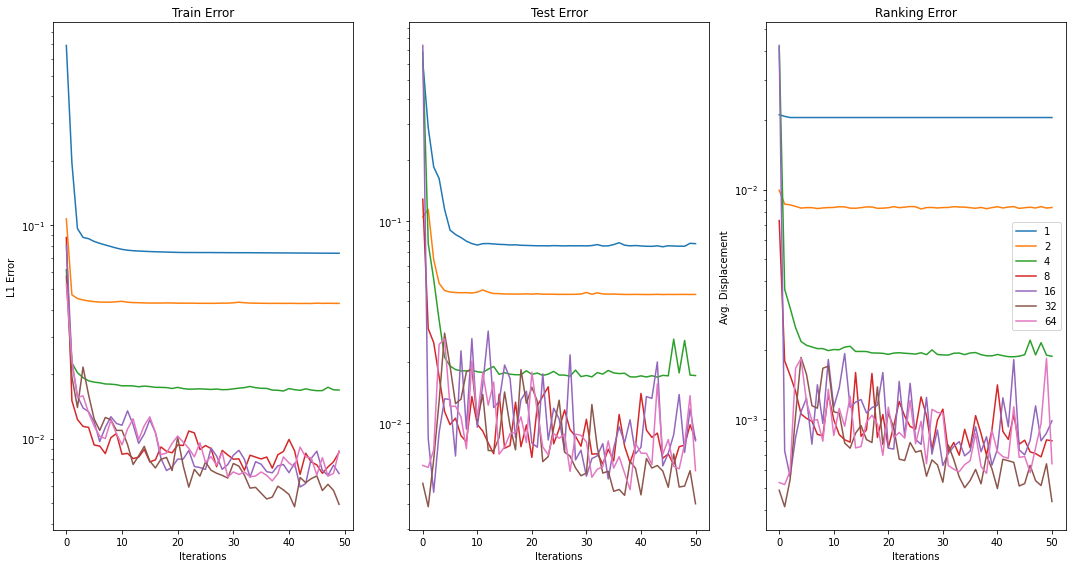

In [8]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16,32,64]):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

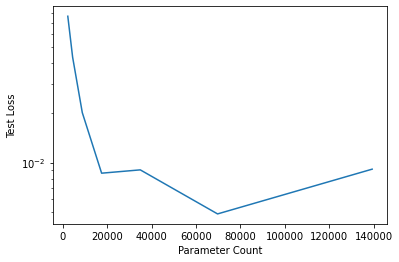

In [13]:
params = [2273,4449,8801,17505,34913,69729,139361]
plt.semilogy(params,[np.mean(graph_results[i][1][-3::]) for i in range(len(graph_results))])
plt.xlabel('Parameter Count')
plt.ylabel('Test Loss');

Increasing network depth to $l=8$ leads to better performance. However, the loss begins to stagnate past this point, and, with the exception of $l=32$,  it is still nearly an order of a magnitude worse than for the initial $p\in{}[\frac{1}{n},\frac{10}{n}]$ dataset. Simply making the model deeper does not result in uniform, sufficient improvement. 

### Is This Oversmoothing?

GCNs suffer from a peculiar phenomena known as *oversmoothing*. In essence,  performance tends to degrade as you add more layers, and the features of each node converge to the same values. We choose to measure smoothing by the layerwise Mean Average Distance [15] i.e:

$$\frac{1}{\sum_{i,j\in{}E}w_{ij}}\sum_{i,j\in{}E}w_{ij}(1 - \frac{x_{j}^{T}x_{i}}{||x_{i}||_{2}||x_{j}||_{2}})$$

where $X\in{}R^{|V|xn}$ is the graph representation matrix. Current theoretical analysis of oversmoothing has been limited to the GCNConv operator of Kipf and Welling [15].

$$X^{l+1} = (D^{\frac{-1}{2}}AD^{\frac{1}{2}})X^{l}W$$

This is a psuedo-spectral convolution, in it that aggregates using a form of the symmetric normalized graph Lapalcian $L_{sym} = I - D^{\frac{-1}{2}}AD^{\frac{1}{2}}$. If $\lambda_{1}$ is the dominant eigenvalue of $(D^{\frac{-1}{2}}AD^{\frac{1}{2}})$, then we can state:

$$\lim_{k\rightarrow{}\infty} (\frac{1}{|\lambda_{1}|})^{k}|(D^{\frac{-1}{2}}AD^{\frac{1}{2}})^{k}\vec{x}| = \lim_{k\rightarrow{}\infty} (\frac{1}{1 - \lambda_{1}})^{k} L_{sym}^{k}\vec{x}$$

The graph Laplacian in analogous to the discrete Laplacian operator in a Cartesian space; it diffuses material until it is distributed evenly across the network (or as much as is possible). This is the root of the overmsoothing problem in GCNConv. However, the literatures demonstrates that spatial convolution algorithms, which do not explicitly incorporate $L_{sym}$, are no less vulnerable to oversmoothing [16,17].



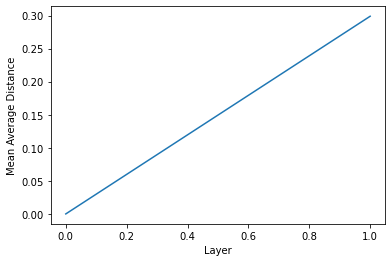

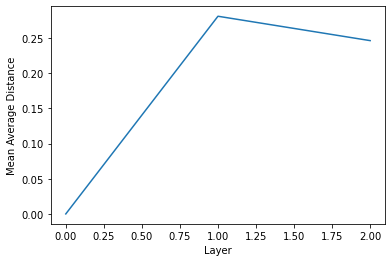

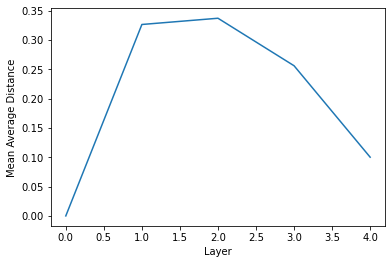

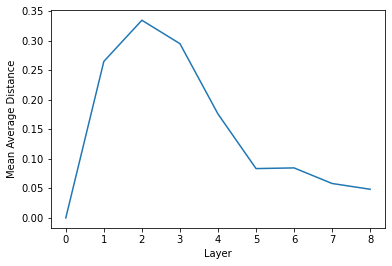

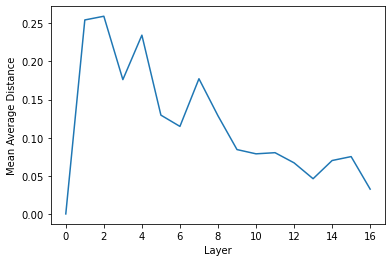

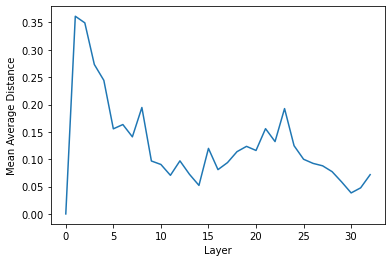

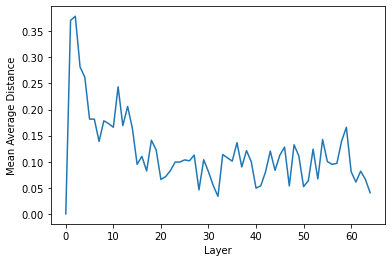

In [11]:
for idx,d in enumerate(model_mad):
  plt.plot(d,label='GraphConv')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')
  plt.show()

We observe a substantial decline in MAD for deeper GCN layers. This indicates that the elements of the dominant eigenvector of $A$, $v_{1}$, are tightly clustered; most converge to similar values in the limit as $l\rightarrow{}\infty$, which manifests as oversmoothing. We can visualize this by looking at the distribution of Katz Centrality:

In [ ]:
for data in test_loader:
    plt.hist(normalize(data.y.cuda(),data.batch.cuda()).cpu(),bins=100,density=True)
    plt.xlabel('Normalized Katz')
    plt.ylabel('Counts')
    break;

The large marjority of nodes have min-max normalized $d_{katz}$ of around $0$. Bearing in mind the relationship between $d_{Katz}$ and $v_{1}$, we can infer that $v_{1}$ is similarily clustered. Problem is, we don't necesarily want to converge to exactly $v_{1}$, as—at these levels of sparsity—the sample networks are unlikely to be strongly connected. 